<a href="https://colab.research.google.com/github/GIStechno/Graph/blob/main/Pfafstetter_Algorithm_final_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pfafstetter Coding Implementation**

Required Packages

In [ ]:
!pip3 install pandas --user # DataFrame ... Pandas is a open source data analysis and manipulation tool, built on top of the Python programming language.
!pip3 install matplotlib --user # Plot ... Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.
!pip3 install numpy --user # Array ... NumPy is a Python library used for working with arrays.
!pip3 install networkx --user # Network ... NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. https://networkx.org/

!pip3 install graphviz --user # visualise results
!pip3 install xlrd --user # xlsx support
!pip3 install openpyxl --user #xlsx support
!pip3 install pickle-mixin --user #import pickle for tests

  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-cp37-none-any.whl size=6007 sha256=d5d81ad4ce64b1f8aaad15c9cfe9ef8e775cc58fd8573654e08c64c01aacdc47
  Stored in directory: /root/.cache/pip/wheels/cd/05/42/71de70fa36b9cbb7657bb5793a16f8028c1cdc1bdd3b8e1ac3
Successfully built pickle-mixin


**Data Inspection**

*   import "attribute table" as data [] (collection types)
*   NODE_B = start node
*   NODE_A = end node
*   SEGMENT_ID = unique ID for each segment (edge or link)
*   LENGTH = the length of between two adjacent nodes

In [ ]:
import numpy as np
import pandas as pd

from google.colab import files
uploaded = files.upload()

#url = 'https://drive.google.com/file/d/1CylDf1Fm0kQGmZ9B9SvgBnrFA-d1ikoZ/view?usp=sharing'
#df1 = pd.read_csv(url)
#df = pandas.read_csv(url, sep='delimiter', header=None)


Saving cakit_basin.xlsx to cakit_basin.xlsx


In [ ]:
import io
df = pd.read_excel(io.BytesIO(uploaded['cakit_basin.xlsx']))
df


,SEGMENT_ID,NODE_A,NODE_B,BASIN,ORDER,ORDER_CELL,LENGTH
0,1,1,5,1,1,7,7552.935060
1,2,2,5,1,1,7,4573.158005
2,3,3,7,1,1,7,5093.452378
3,4,4,11,1,1,7,9990.580079
4,5,5,17,1,2,8,16498.662325
5,6,6,7,1,1,7,2507.939392
6,7,7,15,1,2,8,5545.584412
7,8,8,13,1,1,7,6716.833329
8,9,9,16,1,1,7,6274.112550
9,10,10,13,1,1,7,9723.595231


**## PFAF Algorithm**

In [ ]:
# Pfafstetter Coding Implementation
# -*- coding: utf-8 -*-
"""
***************************************************************************
*    pfaf.py                                                              *
*    ---------------------                                                *
*    Date                 : August 2020                                   *
*    Copyright            : (C) 2020 by Ibrahim Ulucan                    *
*    Email                : ulucan.ibrahim@metu.edu.tr                    *
***************************************************************************
*   The program is Pfafstetter Coding Implementation.                     *
*   Desinging the PFAF class is an extensible program-code-template       *
*   for creating different PFAF objects within the scope of               *
*   the Object Oriented Programming (OOP)                                 *
*                                                                         *
***************************************************************************
"""
#from qgis.PyQt.QtCore import QCoreApplication
#from qgis.core import (QgsProcessing, QgsProcessingAlgorithm)
#from qgis import processing

## Required Packages
'''
!pip3 install networkx --user # network model #https://networkx.org/
!pip3 install pandas --user # pandas
!pip3 install matplotlib --user # drawings
!pip3 install numpy --user # numpy
!pip3 install graphviz --user # data visualization #https://graphviz.readthedocs.io/en/stable/manual.html
!pip3 install pygraphviz --user # data visualization
!pip3 install xlrd --user # xlsx support
!pip3 install openpyxl --user  # xlsx support
'''
## Algorithm ...
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
#import pygraphviz
import xlrd
import openpyxl
import time
import queue
import pickle
import pdb

import io

###PART-I: PFAF CLASS
class Pfaf:
    # read the input files and construct the Data Structure as Binary Tree)
    def __init__(self, file_name=None, net=None):
        #import "attribute table" as data [] (collection types)
        if file_name is not None:
            net = self.load_file(file_name)
        elif net is None:
            print('pfaf= Pfaf(file_input=file_name)')
            print('pfaf = Pfaf(net=networkx_network_object)')
            #try ... catch block -> FileNotFoundError
            #print('ERROR: No input specified...')
            return None
        #Creates a copy of the network to preserve the orginal attribute tables.
        self.org_tree = net.copy()
        self.tree     = net.reverse()
        #Find the path to the end node in terms of shortest distance algorithms 
        #https://networkx.org/documentation/networkx-1.10/reference/algorithms.shortest_paths.html
        self.all_lengths            = dict(nx.all_pairs_shortest_path_length(self.tree))
        #self.all_real_world_lengths = dict(nx.dijkstra_path_length(self.tree, source=G, target=None, weight='LENGTH'))
        self.all_real_world_lengths = dict(nx.floyd_warshall(self.tree, weight='LENGTH'))
        
###PART-II: PFAF FUNCTIONS   
    # loading the input file   
    def load_file(self, file_name):
        #graph_data           = pd.read_excel(file_name)
        #self.graph_data_pure = pd.read_excel(file_name)
        graph_data           = pd.read_excel(io.BytesIO(uploaded['cakit_basin.xlsx']))
        self.graph_data_pure = pd.read_excel(io.BytesIO(uploaded['cakit_basin.xlsx']))
        # Drop the unnecessary attributes in order to decrease the time complexity
        graph_data.drop(['BASIN', 'ORDER', 'ORDER_CELL', 'SEGMENT_ID'], axis=1, inplace=True)
        '''
        Data Inspection:
        import "attribute table" as data [] (collection types)
        NODE_B = start node
        NODE_A = end node
        SEGMENT_ID = unique ID for each segment (edge or link)
        LENGTH = the length of between two adjacent nodes
        '''
        graph_data = graph_data.astype({
            #'NODE_A' : np.float64,
            #'NODE_B' : np.float64, 
            'NODE_A' : np.int32,
            'NODE_B' : np.int32,
            'LENGTH' : np.float64
                          })
        ### Building the Binary Tree
        # Add nodes
        net = nx.DiGraph()
        all_from_nodes = set(graph_data['NODE_A'])
        #NODE_A = end node
        all_to_nodes   = set(graph_data['NODE_B'])
        #NODE_B = start node
        all_nodes = all_from_nodes.union(all_to_nodes)
        net.add_nodes_from(all_nodes)
        # Add edges
        all_edges = zip(graph_data['NODE_A'], graph_data['NODE_B'], map(lambda x:{'LENGTH': x, 'LABEL': ''}, graph_data['LENGTH']))
        net.add_edges_from(list(all_edges))
        return net
        
###PART-II-A: BINARY TREE FUNDAMENTAL FUNCTIONS  
    #start node
    def get_root_org(self):
        org_tree = self.org_tree
        ## Choose root node
        out_zero_nodes = [node for node in org_tree.nodes if org_tree.out_degree(node) == 0]
        # Check if there is a single root, if not, there are more than one exit nodes!
        #start node -> missing sequence node = there is NODE_B (start node) but not exist NODE_A (end note)
        assert len(out_zero_nodes) == 1
        root = out_zero_nodes[0]
        return root
    
    def get_root(self, tree):
        ## Choose root node
        out_zero_nodes = [node for node in tree.nodes if tree.in_degree(node) == 0]
        # Check if there is a single root, if not, there are more than one exit nodes!
        assert len(out_zero_nodes) == 1
        root = out_zero_nodes[0]
        return root
    
    def get_child(self, root):
        children = list(self.tree.successors(root))
        # Be sure it is binary tree.
        assert len(children) == 1
        return children[0]

    def get_children(self, root):
        children = list(self.tree.successors(root))
        # Be sure it is binary tree.
        assert len(children) == 2
        return children

    def get_parent(self, root):
        parent = list(self.tree.predecessors(root))
        # Be sure it is binary tree.
        assert len(parent) == 1
        return parent[0]

    def get_sibling(self, root):
        parent = self.get_parent(root)
        sibling = set(self.get_children(parent)) - set([root])
        sibling = list(sibling)
        # Be sure it is binary tree.
        assert len(sibling) == 1
        return sibling[0]

    def get_longer_child(self, root):
        children = self.get_children(root)
        if self.tree.edges[root, children[0]]['LENGTH'] > self.tree.edges[root, children[1]]['LENGTH']:
            return children[0]
        else:
            return children[1]

    def get_shorter_child(self, root):
        children = self.get_children(root)
        if self.tree.edges[root, children[0]]['LENGTH'] < self.tree.edges[root, children[1]]['LENGTH']:
            return children[0]
        else:
            return children[1]

###PART-II-B: BINARY TREE TRAVERSE FUNCTIONS  
    #find the deepest node wrt DFS (Depth First Search)
    def get_deepest_node(self, tree, start_node):
        '''
        Deepest node is the node which is labelled with 9 [source].
        This function finds the node that is most far from the root node [1] -> outlet.
        Algorithm: Sort each node with respect to: Tree depth & length
        '''
        #leaves = [n for n in nx.dfs_tree(tree, start_node).nodes if self.tree.out_degree(n) == 0]
        leaves = [n for n in nx.dfs_tree(tree, start_node).nodes if tree.out_degree(n) == 0]

        # find the depth
        all_nodes = []
        for node in leaves:
            depth = self.all_lengths[start_node][node]
            real_world_length = self.all_real_world_lengths[start_node][node]
            all_nodes.append((depth, real_world_length, node))

        #sorted by reversed
        end_node = sorted(all_nodes)[-1][-1]
        return end_node
    
    #Return the depth of the tree measured from the given node
    def get_depth(self, tree, node):
        end_node = self.get_deepest_node(tree, node)
        return self.all_lengths[node][end_node]

###PART-III: PFAF LABELLING FUNCTIONS  
    #Add tag to specified edge
    def add_tag(self, from_node, to_node, tag):
        self.tree.edges[from_node, to_node]['LABEL'] = self.tree.edges[from_node, to_node]['LABEL'] + tag
    
    def add_tag_to_children(self, node, tag):
        '''
        Adds nodes to all children recursively.
        If tree is given, than all edges will be updated.
        If node is given, all of the children will be updated that exist in the main graph.
        '''
        if type(node) is nx.DiGraph:
            graph = node

            for from_node, to_node in graph.edges:
                self.add_tag(from_node, to_node, tag)
        
        else:
            target_edges = nx.dfs_tree(self.tree, node).edges
            
            for from_node, to_node in target_edges:
                self.add_tag(from_node, to_node, tag)

###PART-IV: SAVE THE OUTPUT FILES 
    def save_to_file(self, output_file_name):
        graph_data = self.graph_data_pure.copy()

        edge_labels = []
        for index in graph_data.index:
            NODE_A = graph_data.iloc[index]['NODE_A']
            NODE_B = graph_data.iloc[index]['NODE_B']
            edge_labels.append(self.tree.edges[NODE_B, NODE_A]['LABEL'])
        
        #writing the result on the xlsx files as new column named by 'PFAFSTETTER CODE'
        graph_data['PFAFSTETTER CODE'] = pd.Series(edge_labels, index=graph_data.index)
        graph_data.to_excel(output_file_name)

   ###PART-VI: PFAF PROCESS FUNCTION
    """
    **********************************************************************************
    *   Recursive data structures (structural recursion):                            *
    *   --------------------------------------------------                           *
    *   ALL CASES : The major tree is changed by sub-tree due to find the            *
    *               suitable cases wrt tree-depth recursively                        *
    *   CASE-0   : NO CASE (here should be no processing. just retun input values)   *
    *   CASE-I   : tree depth == 1                                                   *
    *   CASE-II  : tree depth == 2                                                   *
    *   CASE-III : tree depth == 3                                                   *
    *   CASE-IV  : tree depth == 4                                                   *
    *   CASE-V   : ALL THE OTHER CASES                                               *
    **********************************************************************************
    """

    def process(self):
        print('Processing... ', flush=True, end='')
        start_time = time.time()
        new_root = self.get_child(self.get_root(self.tree))
        self.process_tree(nx.dfs_tree(self.tree, new_root), new_root)
        print('Completed in ', time.time() - start_time, ' seconds :)')
    
    def process_tree(self, subtree, root):
        #### ALL CASES
        # the major tree is changed by sub-tree due to find the suitable cases wrt tree-depth recursively

        ### CASE-0 : NO CASE
        if len(subtree.nodes) == 1:
            # There should be no processing. just retun input values
            return
        #print(root)
        self.add_tag(self.get_parent(root), root, '1')

        ### CASE-I : tree depth == 1
        if self.get_depth(subtree, root) == 1:
            # Nodes are named by edges above them
            longer_child  = self.get_longer_child(root)
            shorter_child = self.get_shorter_child(root)

            self.add_tag(root, longer_child, '9')
            self.add_tag(root, shorter_child, '2')
            return

        ### CASE-II : tree depth == 2
        if self.get_depth(subtree, root) == 2:
            # Nodes are named by edges above them
            node_9 = self.get_deepest_node(subtree, root)
            node_3 = self.get_parent(node_9)
            node_4 = self.get_sibling(node_9)
            node_2 = self.get_sibling(node_3)
            node_1 = self.get_parent(node_2)
            
            self.add_tag(node_1, node_2, '2')
            self.add_tag(node_1, node_3, '3')
            self.add_tag(node_3, node_4, '4')
            self.add_tag(node_3, node_9, '9')

            # Note that edge network 2 may start another network!
            self.add_tag_to_children(nx.dfs_tree(subtree, node_2), '2')
            self.process_tree(nx.dfs_tree(subtree, node_2), node_2)
            return

        ### CASE-III : tree depth == 3
        if self.get_depth(subtree, root) == 3:
            # Nodes are named by edges above them
            node_9 = self.get_deepest_node(subtree, root)
            node_5 = self.get_parent(node_9)
            node_6 = self.get_sibling(node_9)
            node_3 = self.get_parent(node_5)
            node_4 = self.get_sibling(node_5)
            node_2 = self.get_sibling(node_3)
            node_1 = self.get_parent(node_2)

            self.add_tag(node_1, node_2, '2')
            self.add_tag(node_1, node_3, '3')
            self.add_tag(node_3, node_4, '4')
            self.add_tag(node_3, node_5, '5')
            self.add_tag(node_5, node_6, '6')
            self.add_tag(node_5, node_9, '9')

            # Note that edge network 2 and 4 may start another network!
            self.add_tag_to_children(nx.dfs_tree(subtree, node_2), '2')
            self.add_tag_to_children(nx.dfs_tree(subtree, node_4), '4')
            self.process_tree(nx.dfs_tree(subtree, node_2), node_2)
            self.process_tree(nx.dfs_tree(subtree, node_4), node_4)
            return

        ### CASE-IV : tree depth == 4
        if self.get_depth(subtree, root) == 4:
            # Nodes are named by edges above them
            node_9 = self.get_deepest_node(subtree, root)
            node_8 = self.get_sibling(node_9)
            node_7 = self.get_parent(node_9)
            node_6 = self.get_sibling(node_7)
            node_5 = self.get_parent(node_7)
            node_4 = self.get_sibling(node_5)
            node_3 = self.get_parent(node_5)
            node_2 = self.get_sibling(node_3)
            node_1 = self.get_parent(node_2)

            self.add_tag(node_1, node_2, '2')
            self.add_tag(node_1, node_3, '3')
            self.add_tag(node_3, node_4, '4')
            self.add_tag(node_3, node_5, '5')
            self.add_tag(node_5, node_6, '6')
            self.add_tag(node_5, node_7, '7')
            self.add_tag(node_7, node_8, '8')
            self.add_tag(node_7, node_9, '9')

            # Note that edge network 2, 4 and 6 may start another network!
            self.add_tag_to_children(nx.dfs_tree(subtree, node_2), '2')
            self.add_tag_to_children(nx.dfs_tree(subtree, node_4), '4')
            self.add_tag_to_children(nx.dfs_tree(subtree, node_6), '6')

            self.process_tree(nx.dfs_tree(subtree, node_2), node_2)
            self.process_tree(nx.dfs_tree(subtree, node_4), node_4)
            self.process_tree(nx.dfs_tree(subtree, node_6), node_6)
            return
        
        ### CASE-V : ALL THE OTHER CASES
        end_node = self.get_deepest_node(subtree, root)
        path = nx.shortest_path(subtree, source=root, target=end_node)
        
        #1. Calculate all possible neighbor nodes and select the longest 4 in terms of the biggest 4 tributary [2, 4, 6, 8]
        even_candidates = [(self.all_real_world_lengths[self.get_sibling(node)][self.get_deepest_node(subtree, self.get_sibling(node))] + self.tree.edges[self.get_parent(node), self.get_sibling(node)]['LENGTH'], self.get_sibling(node)) for node in path[1:]]
        
        even_candidates = sorted(even_candidates)
        even_candidates = even_candidates[-4:]
        
        even_targets    = list(map(lambda x: x[1], even_candidates)); del even_candidates # avoid confusion...
        
        #2. Label through for evens...[2, 4, 6, 8] -> tributary
            ##finding all sub-tributary RECURSIVELY !!!
        name_iterator = iter([2, 4, 6, 8])
        for node in path[1:]:
            sibling_node = self.get_sibling(node)
            if sibling_node in even_targets:
                it = str(next(name_iterator))

                self.add_tag(self.get_parent(node), sibling_node, it)
                self.add_tag_to_children(nx.dfs_tree(subtree, sibling_node), it)
                self.process_tree(nx.dfs_tree(subtree, sibling_node), sibling_node)
        
        #3. Label through for odds...[1, 3, 5, 7, 9] -> main stem (9=Source, 1=Outlet)
        name_iterator = iter([1, 3, 5, 7, 9])
        current_label = str(next(name_iterator))
        odd_subtrees  = {1: subtree}
        even_subtrees = {}
        for node in path[1:]:
            if self.get_sibling(node) in even_targets:
                current_label = next(name_iterator)
                self.add_tag(self.get_parent(node), node, str(current_label))
                odd_subtrees[current_label]    = nx.dfs_tree(subtree, node)
                even_subtrees[current_label-1] = nx.dfs_tree(subtree, self.get_sibling(node))
                
        #4. Remove extra nodes.
        for label in [7, 5, 3, 1]:
            new_subtree = odd_subtrees[label].copy()
            
            temp_tree = new_subtree.copy()
            new_subtree.remove_nodes_from(n for n in temp_tree if n in even_subtrees[label+1])
            temp_tree = new_subtree.copy()
            new_subtree.remove_nodes_from(n for n in temp_tree if n in odd_subtrees[label+2])
            
            self.add_tag_to_children(new_subtree, str(label))
            self.process_tree(new_subtree, self.get_root(new_subtree))

        #5. Process 9 finally. [9] -> source
        self.add_tag_to_children(odd_subtrees[9], '9')
        self.process_tree(odd_subtrees[9], self.get_root(odd_subtrees[9]))
        return


###PART-V: VISUALIZATION -nice to have- # https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_labels_and_colors.html
    def visualize(self, edge_labels=True, tree=True, colors=None, fig_size=(32,36)):
        netG = self.tree
        plt.figure(figsize=fig_size)
        if tree:
            pss=nx.drawing.nx_agraph.graphviz_layout(netG, prog='dot')
            if colors is not None:
                nx.draw(netG, pss, with_labels=True, arrows=True, edges=netG.edges, edge_color=colors)
            else:
                nx.draw(netG, pss, with_labels=True, arrows=True)
        else:
            pss = nx.spring_layout(netG, k=0.10,iterations=30)
            nx.draw_networkx_nodes(netG, pos=pss, nodelist=netG.nodes, node_color='orange')
            nx.draw_networkx_labels(netG, pos=pss)
            nx.draw_networkx_edges(netG, pos=pss)
        if edge_labels:
            nx.draw_networkx_edge_labels(netG, pos=pss)
        #plt.show()


**PFAFSTETTER MAIN CLASS**

In [ ]:
def main():
    
    ### Creating Pfaf Object
    #from pfaf import Pfaf
    pfaf_object = Pfaf(file_name='cakit_basin.xlsx')
    
    ### Find Labels Based on Pfafstetter Coding
    pfaf_object.process()

    ### Save & Download to Pfafstetter Output File
    pfaf_object.save_to_file('cakit_pfaf_output.xlsx')
    from google.colab import files
    files.download('cakit_pfaf_output.xlsx')

    return pfaf_object

    ### Visualise Results - nice to have
    pfaf2.visualize(fig_size=(16,36)) # set larger figure size if overlap occurs

if __name__ == "__main__":
    main()

Processing... Completed in  0.0047833919525146484  seconds :)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



---

---

---

##**Data Visualization**

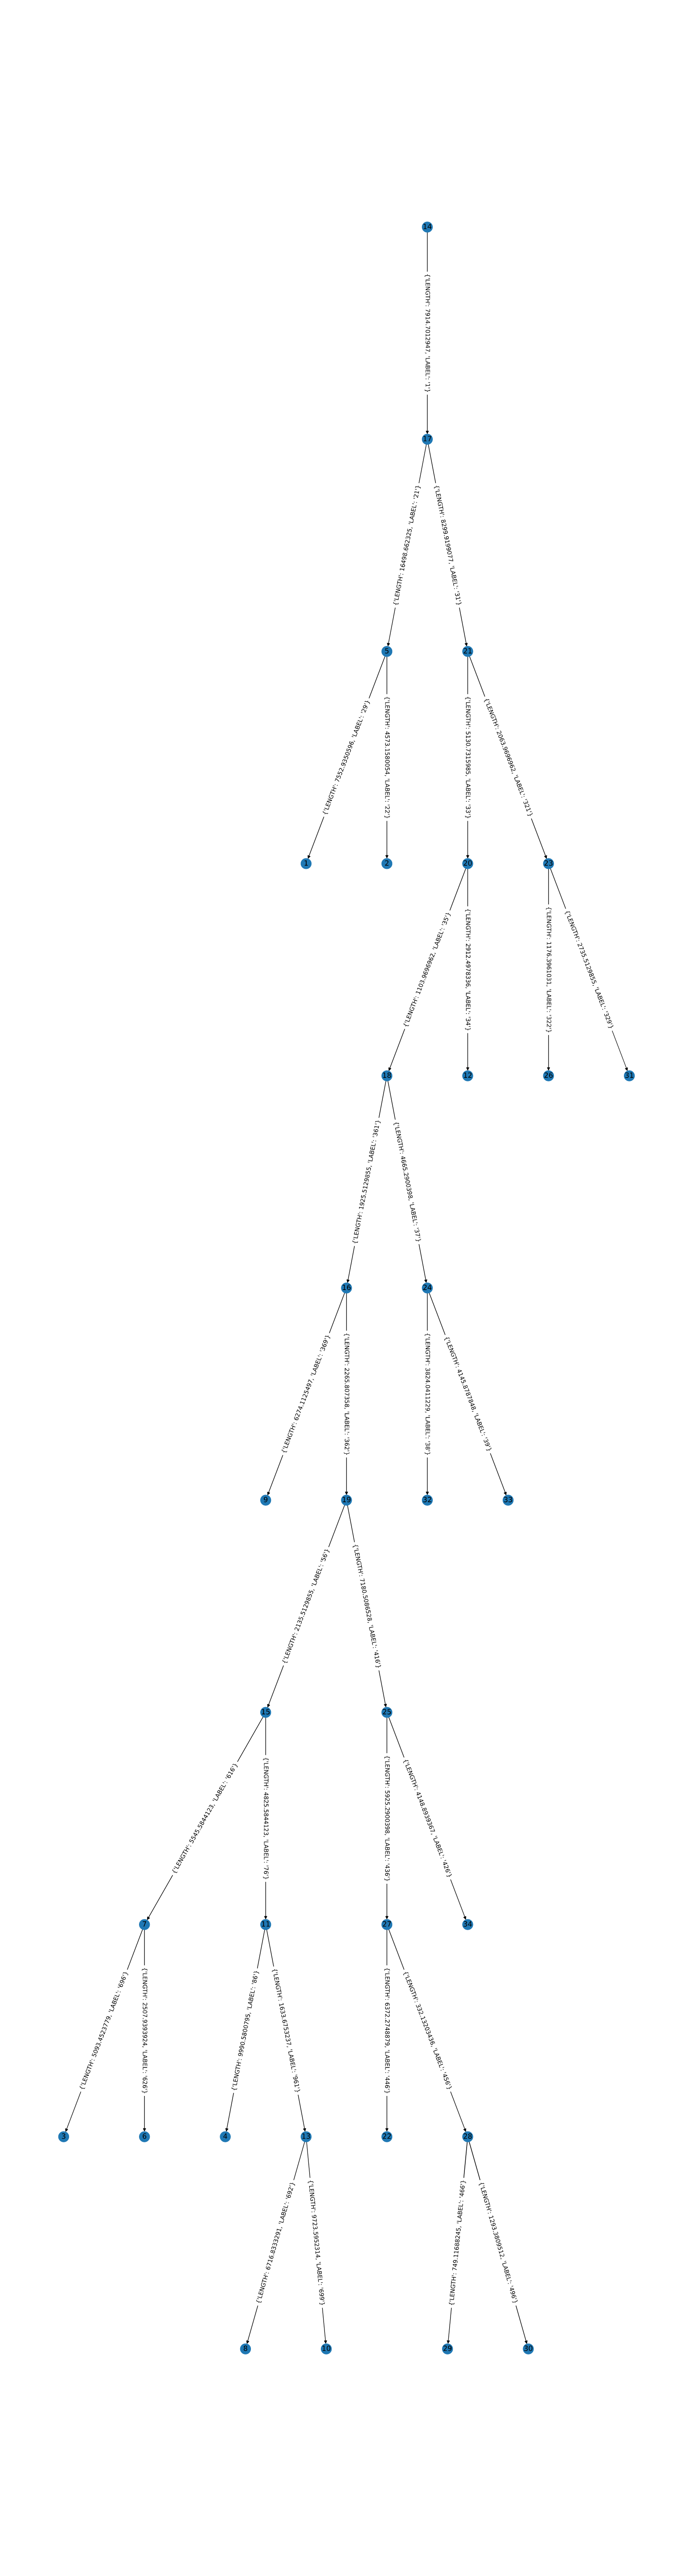

https://github.com/GIStechno/Graph.git